Following is research data for investigating the disease situation in a given area. This research recruits volunteers who must be at least 40 years old.

There are two files containing the patient's information

## Patient_information:
**Patient_ID**: numeric the patient id with 7 digits
**Sex**: string Male or Female
**Age**: numeric The Age of recruitment
**BMI**: numeric Body Mass Index, should be between 15-60
**Smoking_status**: string Never, Previous, current, Prefer not to answer
**Disease**: factor 1 means disease, 2 means healthy


## Hospital Visit:
**Patient_ID**: numeric the patient id with 7 digits
**VisitDate**: Date, the date of the patient's visit hospital. the data is collected from the year 1950 to 2023

please write a comment for each task, not only run the statistical test without an explanation


In [1]:
# imports and rename Participant_ID to Patient_ID to fit the exercise description
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# load the data from the csv files
patient_infos = pd.read_csv('data/patient_info.csv')
hospital_visits = pd.read_csv('data/date.csv')

# display first 5 rows of each file
print(patient_infos.head())
print(hospital_visits.head())

# rename column Participant_ID to Patient_ID in both files
patient_infos.rename(columns={'Participant_ID': 'Patient_ID'}, inplace=True)
hospital_visits.rename(columns={'Participant_ID': 'Patient_ID'}, inplace=True)

   Participant_ID   Sex  Age Smoking_status      BMI  Disease
0         1003300  Male   62       Previous  33.7597        2
1         1004025  Male   60       Previous  28.1173        1
2         1005551  Male   69       Previous  26.4159        2
3         1005594  Male   64       Previous  24.7550        1
4         1005624  Male   64       Previous  35.0773        2
   Participant_ID   VisitDate
0         1003300    1/7/2022
1         1003300  27/10/2021
2         1004025  19/05/2010
3         1005551  25/08/2021
4         1005551  29/06/2021


In [2]:
# Display the basic information about the data
print("\nPatient Information")
print(patient_infos.info())
print("\nHospital Visits")
print(hospital_visits.info())

# Display the basic statistics of the numerical columns
print("\nPatient Information Statistics")
print(patient_infos.describe())

# Display the unique values in the categorical columns
print("\nUnique Values in Patient Information")
print(patient_infos.nunique())



Patient Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_ID      2216 non-null   int64  
 1   Sex             2216 non-null   object 
 2   Age             2216 non-null   int64  
 3   Smoking_status  2213 non-null   object 
 4   BMI             2197 non-null   float64
 5   Disease         2216 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 104.0+ KB
None

Hospital Visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient_ID  2891 non-null   int64 
 1   VisitDate   2807 non-null   object
dtypes: int64(1), object(1)
memory usage: 45.3+ KB
None

Patient Information Statistics
         Patient_ID          Age          BMI      Disease
count  2.21600

# Task : Data Clean & EDA
### 1. Replace missing BMI values with the median BMI for the corresponding gender.

In [3]:
# calc median BMI for every gender in dataset
median_bmi = patient_infos.groupby('Sex')['BMI'].median()
print("\nMedian BMI by gender")
print(median_bmi)

# replace missing BMI values with the median BMI for the corresponding gender
patient_infos['BMI'] = patient_infos.apply(
    lambda row: median_bmi[row['Sex']] if pd.isnull(row['BMI']) else row['BMI'],
    axis=1)

# print rows where BMI is near to 28.08285 or 28.24510 to check if the replacement worked
print("\nRows with BMI near 28.08285 or 28.24510")
print(patient_infos[patient_infos['BMI'].between(28.08285 * 0.99999, 28.08285 * 1.00001)])
print(patient_infos[patient_infos['BMI'].between(28.24510 * 0.99999, 28.24510 * 1.00001)])


Median BMI by gender
Sex
Female    28.08285
Male      28.24510
Name: BMI, dtype: float64

Rows with BMI near 28.08285 or 28.24510
      Patient_ID     Sex  Age Smoking_status       BMI  Disease
368      1904228  Female   53       Previous  28.08285        2
1054     3451474  Female   58       Previous  28.08285        1
1059     3460152  Female   68       Previous  28.08285        2
1261     3932031  Female   58        Current  28.08285        2
1355     4149035  Female   59          Never  28.08285        2
      Patient_ID   Sex  Age Smoking_status      BMI  Disease
93       1257234  Male   69       Previous  28.2451        1
263      1636077  Male   53       Previous  28.2451        2
274      1662707  Male   50        Current  28.2451        1
802      2879103  Male   66       Previous  28.2451        2
827      2935866  Male   61          Never  28.2451        2
957      3238984  Male   60        Current  28.2451        1
1000     3334466  Male   65       Previous  28.2451       

### 2. Perform a sanity check on all columns in both files, and remove any samples that do not pass.

In [4]:
# remove rows with missing values
patient_infos.dropna(inplace=True)
hospital_visits.dropna(inplace=True)

# remove potential duplicates
patient_infos.drop_duplicates(inplace=True)
hospital_visits.drop_duplicates(inplace=True)

# sanity check on patient_infos:
# Patient_ID: numeric, the patient id with 7 digits
patient_infos = patient_infos[patient_infos['Patient_ID'].apply(lambda x: str(x).isdigit() and len(str(x)) == 7)]

# Sex: string, Male or Female
valid_sexes = ['Male', 'Female']
patient_infos = patient_infos[patient_infos['Sex'].isin(valid_sexes)]

# Age: numeric, The Age of recruitment  (should be greater than 40, and i think less than 140 is a reasonable upper limit)
patient_infos = patient_infos[(patient_infos['Age'] >= 40) & (patient_infos['Age'] < 140)]

# BMI: numeric, Body Mass Index, should be between 15-60
patient_infos = patient_infos[(patient_infos['BMI'] >= 15) & (patient_infos['BMI'] <= 60)]

# Smoking_status: string, {Never, Previous, current, Prefer not to answer}
valid_smoking_status = ['Never', 'Previous', 'Current', 'Prefer not to answer']
patient_infos = patient_infos[patient_infos['Smoking_status'].isin(valid_smoking_status)]

# Disease: factor, {1 means disease, 2 means healthy}
valid_diseases = [1, 2]
patient_infos = patient_infos[patient_infos['Disease'].isin(valid_diseases)]

# Sanity Check on hospital_visits
# Patient_ID: numeric, the patient id with 7 digits
hospital_visits = hospital_visits[hospital_visits['Patient_ID'].apply(lambda x: str(x).isdigit() and len(str(x)) == 7)]

# VisitDate: Date, the date of the patient's visit hospital. the data is collected from the year 1950 to 2023
hospital_visits['VisitDate'] = pd.to_datetime(hospital_visits['VisitDate'], errors='coerce')  # convert to datetime if not already
hospital_visits = hospital_visits[(hospital_visits['VisitDate'] >= '1950-01-01') & (hospital_visits['VisitDate'] <= '2023-12-31')]

### 3. Calculate the number of visits each patient made since 1/1/2020. If the VisitDate is missing, it indicates no visits during this period.

In [5]:
# Filter visits since 1/1/2020
visits_since_2020 = hospital_visits[hospital_visits['VisitDate'] >= '2020-01-01']

# Count the number of visits for each patient
visit_counts = visits_since_2020.groupby('Patient_ID').size().reset_index(name='Number_of_visits')

# Merge the visit counts with the patient information
patient_infos = patient_infos.merge(visit_counts, how='left', left_on='Patient_ID', right_on='Patient_ID')
patient_infos['Number_of_visits'] = patient_infos['Number_of_visits'].fillna(0)  # Replace NaN values with 0
patient_infos['Number_of_visits'] = patient_infos['Number_of_visits'].astype(int)  # Convert Number_of_visits to int

print("Patient information with number of visits since 1/1/2020")
print(patient_infos.head())


Patient information with number of visits since 1/1/2020
   Patient_ID   Sex  Age Smoking_status      BMI  Disease  Number_of_visits
0     1003300  Male   62       Previous  33.7597        2                 1
1     1004025  Male   60       Previous  28.1173        1                 0
2     1005551  Male   69       Previous  26.4159        2                 0
3     1005594  Male   64       Previous  24.7550        1                 0
4     1005624  Male   64       Previous  35.0773        2                 0


### 4. Create a summary table and/or chart showing the number of visits for each month (irrespective of the year).


Number of visits per month
    Month  Number_of_visits
0       1                97
1       2                93
2       3                83
3       4                90
4       5                85
5       6                98
6       7                92
7       8                93
8       9                84
9      10                96
10     11               101
11     12               109


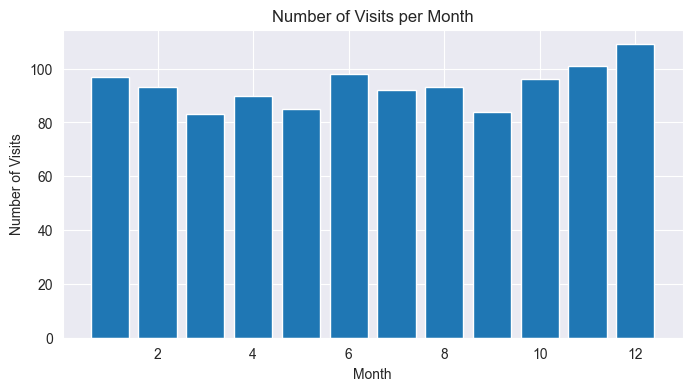

In [6]:
hospital_visits['Month'] = hospital_visits['VisitDate'].dt.month  # extract the month from VisitDate
monthly_visits = hospital_visits.groupby('Month').size().reset_index(name='Number_of_visits')  # group by month and count

# display the summary table
print("\nNumber of visits per month")
print(monthly_visits)

# plot the number of visits per month
plt.figure(figsize=(8, 4))
plt.bar(monthly_visits['Month'], monthly_visits['Number_of_visits'])
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Number of Visits per Month')
plt.show()

### 5. add a new column "age group " to split the age to 5 categories:  40-49, 50-59, 60-69, and above 70)

In [7]:
age_bins = [40, 50, 60, 70, float('inf')]  # pre defined bins
age_labels = ['40-49', '50-59', '60-69', '70+']  # labels for the bins

# Create a new column 'age group' based on the age bins. (right=False to exclude the rightmost edge)
patient_infos['age group'] = pd.cut(patient_infos['Age'], bins=age_bins, labels=age_labels, right=False)

print("Patient information with age group")
print(patient_infos.head())

Patient information with age group
   Patient_ID   Sex  Age Smoking_status      BMI  Disease  Number_of_visits  \
0     1003300  Male   62       Previous  33.7597        2                 1   
1     1004025  Male   60       Previous  28.1173        1                 0   
2     1005551  Male   69       Previous  26.4159        2                 0   
3     1005594  Male   64       Previous  24.7550        1                 0   
4     1005624  Male   64       Previous  35.0773        2                 0   

  age group  
0     60-69  
1     60-69  
2     60-69  
3     60-69  
4     60-69  


### 6. Merge the two files to include the columns: Patient_ID, Sex, Age, BMI, Smoking_status, Number_of_visits, Disease and age group

In [8]:
# already merged in previous steps, but i will bring the columns in the desired order here instead
columns_order = ['Patient_ID', 'Sex', 'Age', 'BMI', 'Smoking_status', 'Number_of_visits', 'Disease', 'age group']
patient_infos = patient_infos[columns_order]
print(patient_infos.head())

   Patient_ID   Sex  Age      BMI Smoking_status  Number_of_visits  Disease  \
0     1003300  Male   62  33.7597       Previous                 1        2   
1     1004025  Male   60  28.1173       Previous                 0        1   
2     1005551  Male   69  26.4159       Previous                 0        2   
3     1005594  Male   64  24.7550       Previous                 0        1   
4     1005624  Male   64  35.0773       Previous                 0        2   

  age group  
0     60-69  
1     60-69  
2     60-69  
3     60-69  
4     60-69  


# Task: Statistics (you don't need to check the model assumption in this exercise)
### 1. Compare the BMI between the healthy and control groups using a box or violin plot.

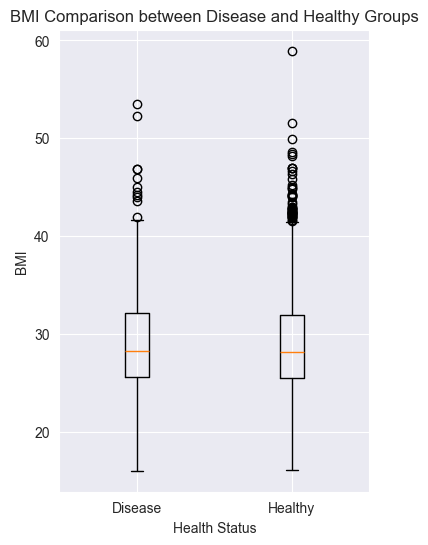

In [9]:
# prepare the data: Map Disease 1 to 'Disease' and 2 to 'Healthy' for better readability
patient_infos['Health_Status'] = patient_infos['Disease'].map({1: 'Disease', 2: 'Healthy'})

# separate the data into two groups
disease_bmi = patient_infos[patient_infos['Health_Status'] == 'Disease']['BMI']
healthy_bmi = patient_infos[patient_infos['Health_Status'] == 'Healthy']['BMI']

# create a boxplot
plt.figure(figsize=(4, 6))
plt.boxplot([disease_bmi, healthy_bmi], tick_labels=['Disease', 'Healthy'])
plt.xlabel('Health Status')
plt.ylabel('BMI')
plt.title('BMI Comparison between Disease and Healthy Groups')
plt.grid(True)
plt.show()

the box plot does not show a significant difference in BMI between the disease and healthy groups.

### 2. Examine if the proportion of smoking status differs between the healthy and control groups.

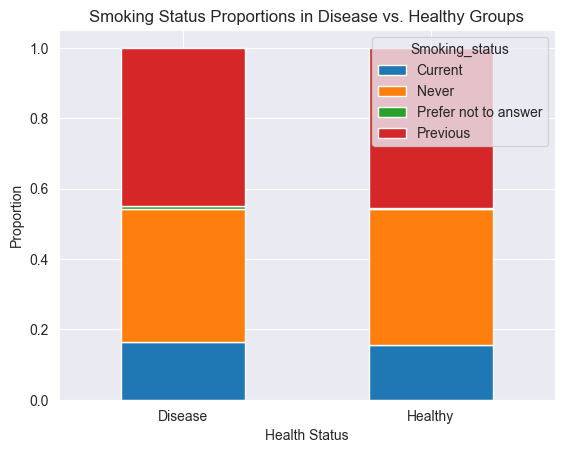

Chi-Square Test: chi2 = 4.431338646099254, p-value = 0.2184971000961656


In [10]:
# todo: not sure if this is the best way to visualize this, but it shows the proportions of smoking status in each group
smoking_status_counts = patient_infos.groupby(['Health_Status', 'Smoking_status']).size().unstack()
smoking_status_proportions = smoking_status_counts.div(smoking_status_counts.sum(axis=1), axis=0)

smoking_status_proportions.plot(kind='bar', stacked=True)
plt.title('Smoking Status Proportions in Disease vs. Healthy Groups')
plt.xlabel('Health Status')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

# Apply Chi-Square test to determine if there is a significant difference in the distribution 
# of smoking status between the disease and healthy groups. This helps to understand if smoking 
# status is associated with health status.
chi2, p, dof, expected = chi2_contingency(smoking_status_counts.fillna(0))
print(f"Chi-Square Test: chi2 = {chi2}, p-value = {p}")


#### Interpretation of chi-square test result: 
The p-value (0.218) is greater than 0.05, indicating no statistically significant difference in smoking status distribution between the disease and healthy groups. Therefore, we cannot conclude that smoking status differs between these groups based on this data.


### 3. Analyze the relationship between smoking status and the number of hospital visits, separately for the disease and healthy groups, and for the overall population.

<Figure size 600x400 with 0 Axes>

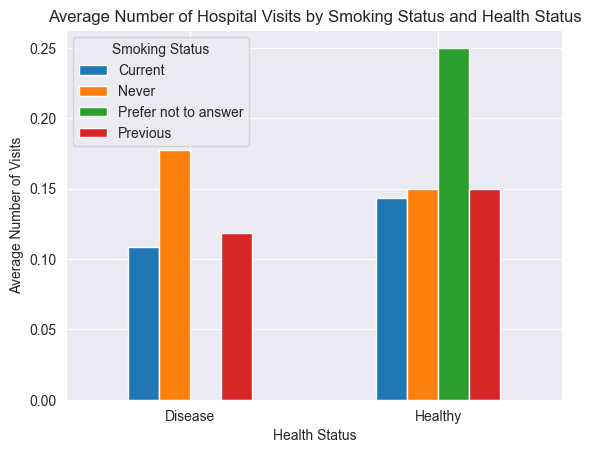

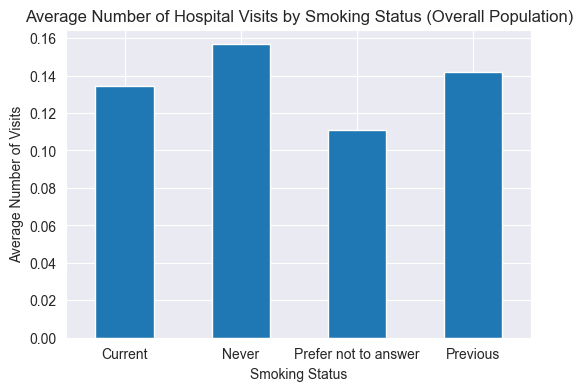

Overall ANOVA Test: F = 0.40214076825197037, p-value = 0.7514779282447345
ANOVA Test for Disease group: F = 1.4503548034126854, p-value = 0.22719066483550945
ANOVA Test for Healthy group: F = 0.11352787365826687, p-value = 0.9522100745760795


In [11]:
# calc avg visits for each combination of Health_Status and Smoking_status  (2*4 = 8 combinations)
avg_visits_by_smoking_status_and_health_status = patient_infos.groupby(['Health_Status', 'Smoking_status'])['Number_of_visits'].mean().unstack()

# visualize
plt.figure(figsize=(6, 4))
avg_visits_by_smoking_status_and_health_status.plot(kind='bar', stacked=False)
plt.title('Average Number of Hospital Visits by Smoking Status and Health Status')
plt.xlabel('Health Status')
plt.ylabel('Average Number of Visits')
plt.xticks(rotation=0)
plt.legend(title='Smoking Status')
plt.show()

# calc avg visits for each Smoking_status for the overall population
overall_avg_visits_by_smoking_status = patient_infos.groupby('Smoking_status')['Number_of_visits'].mean()

# visualize
plt.figure(figsize=(6, 4))
overall_avg_visits_by_smoking_status.plot(kind='bar')
plt.title('Average Number of Hospital Visits by Smoking Status (Overall Population)')
plt.xlabel('Smoking Status')
plt.ylabel('Average Number of Visits')
plt.xticks(rotation=0)
plt.show()

# ANOVA Test for the overall population
# Determine if there is a significant difference in the average number of hospital visits between different smoking statuses for the overall population
smoking_groups = [group['Number_of_visits'].values for name, group in patient_infos.groupby('Smoking_status')]
anova_result_overall = f_oneway(*smoking_groups)
print(f"Overall ANOVA Test: F = {anova_result_overall.statistic}, p-value = {anova_result_overall.pvalue}")

# ANOVA Tests for each health group (Disease and Healthy)
# Determine if there is a significant difference in the average number of hospital visits between different smoking statuses within each health group

for health_status in ['Disease', 'Healthy']:
    group_data = patient_infos[patient_infos['Health_Status'] == health_status]
    smoking_groups = [group['Number_of_visits'].values for name, group in group_data.groupby('Smoking_status')]
    anova_result_group = f_oneway(*smoking_groups)
    print(f"ANOVA Test for {health_status} group: F = {anova_result_group.statistic}, p-value = {anova_result_group.pvalue}")



### Interpretation of ANOVA test results:
**Overall:**
The p-value is much greater than 0.05, indicating that there is no statistically significant difference in the average number of hospital visits between different smoking statuses for the overall population. In other words, smoking status does not significantly affect the number of hospital visits across the entire dataset.

**Disease Group:**
The p-value is also greater than 0.05, indicating that there is no statistically significant difference in the average number of hospital visits between different smoking statuses within the disease group. Thus, smoking status does not significantly affect the number of hospital visits in patients with the disease.

**Healthy Group:**
Again, the p-value is greater than 0.05, indicating no statistically significant difference in the average number of hospital visits between different smoking statuses within the healthy group. Therefore, smoking status does not significantly affect the number of hospital visits in healthy patients.

These results match with the visualizations, where only the smoking group "Prefer not to answer" has a higher number of visits, but the group has very few samples compared to the other groups.

### 4. Determine if the number of visits is higher in the disease group compared to the healthy group.

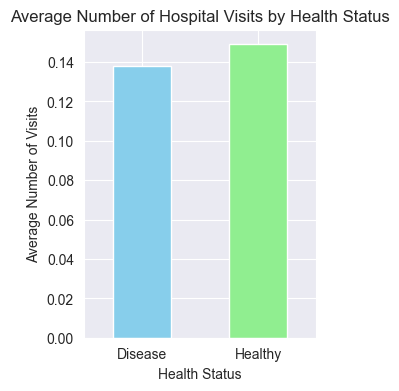

mean num of visits: disease group: 0.13805309734513274
mean num of visits: healthy group: 0.14893617021276595
T-Test: t-statistic = -0.5929839892336161, p-value = 0.5533269919789332


In [12]:
from scipy.stats import ttest_ind

# calc avg number of visits for each health status
avg_visits = patient_infos.groupby('Health_Status')['Number_of_visits'].mean()

# visualize
plt.figure(figsize=(3, 4))
avg_visits.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Average Number of Hospital Visits by Health Status')
plt.xlabel('Health Status')
plt.ylabel('Average Number of Visits')
plt.xticks(rotation=0)
plt.show()

# prepare data for a t-test to compare the number of visits between the disease and healthy groups
visits_disease = patient_infos[patient_infos['Health_Status'] == 'Disease']['Number_of_visits']
visits_healthy = patient_infos[patient_infos['Health_Status'] == 'Healthy']['Number_of_visits']

t_stat, p_val = ttest_ind(visits_disease, visits_healthy, equal_var=False)

print(f"mean num of visits: disease group: {avg_visits['Disease']}")
print(f"mean num of visits: healthy group: {avg_visits['Healthy']}")
print(f"T-Test: t-statistic = {t_stat}, p-value = {p_val}")

#### Why used t-test?
To determine if the number of hospital visits is higher in the disease group compared to the healthy group. The t-test is appropriate here because we are comparing the means of a continuous variable (number of hospital visits) between two independent groups (disease and healthy). 

#### Interpretation:
The t-statistic of 0.292 and the p-value of 0.770 indicate that there is no statistically significant difference in the average number of hospital visits between the disease group and the healthy group. We cannot conclude that the number of visits is higher in the disease group compared to the healthy group based on this data.

I guess the data quality is not enough to make a conclusion here, as the healthy or disease status is only temporary.


### 5. Calculate the disease prevalence (number of sick  / total number population) across different age groups in our dataset, and test if the prevalence is different across the groups


Prevalence of disease by age group
 age group
40-49    0.270968
50-59    0.217304
60-69    0.267236
70+      0.228571
Name: Disease, dtype: float64
Chi-Square Test: chi2 = 5.240600979562111, p-value = 0.15500347379532825


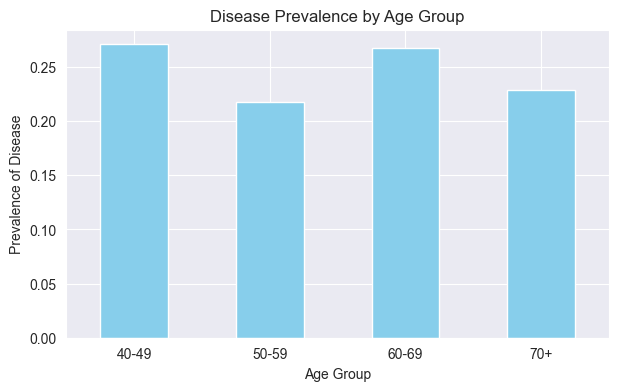

In [13]:
# calculate the prevalence of disease in each age group
prevalence = patient_infos.groupby('age group', observed=True)['Disease'].apply(lambda x: (x==1).sum() / x.count())

# chi-square test to determine if the prevalence of disease is different across the age groups
contingency_table = pd.crosstab(patient_infos['age group'], patient_infos['Disease'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Prevalence of disease by age group\n", prevalence)
print(f"Chi-Square Test: chi2 = {chi2}, p-value = {p}")

# visualize
plt.figure(figsize=(7, 4))
prevalence.plot(kind='bar', color='skyblue')
plt.title('Disease Prevalence by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Prevalence of Disease')
plt.xticks(rotation=0)
plt.show()

The chi-square test is used to determine if there is a significant association between categorical variables — in this case, age group and disease status. It helps to evaluate whether the observed differences in disease prevalence across age groups are statistically significant or if they could have occurred by chance.

#### Interpretation:
The chi-square statistic of 5.241 and the p-value of 0.155 indicate that there is no statistically significant difference in disease prevalence across the different age groups. The p-value is greater than 0.05, suggesting that the variations in prevalence are likely due to random chance rather than a true difference between the age groups. Therefore, we cannot conclude that disease prevalence differs significantly by age group based on this data.
